### 03_word2vec

In [5]:
import os
import bz2
import nltk

words = []
file_path = os.path.join(".","data" ,"wikipedia2text-extracted.txt.bz2")
with bz2.BZ2File(file_path) as f:
    print("Starting Reading data")
    file_string = f.read().decode("utf-8")
    file_string = nltk.word_tokenize(file_string)
    words.extend(file_string)

print('Data size %d' % len(words))
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Starting Reading data
Data size 11634270
Example words (start):  ['Propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['useless', 'for', 'cultivation', '.', 'and', 'people', 'have', 'sex', 'there', '.']


In [18]:
import collections

vocab_size = 30000
count = [["UNK",-1]]
count.extend(collections.Counter(words).most_common(vocab_size-1))
dictionary = dict()

for word, _ in count:
    dictionary[word] = len(dictionary)
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0
        unk_count += 1
    data.append(index)
    
count[0][1] = unk_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
assert len(dictionary) == vocab_size
print([words[:100]])

[['Propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing', 'the', 'opinions', 'or', 'behavior', 'of', 'large', 'numbers', 'of', 'people', '.', 'Instead', 'of', 'impartially', 'providing', 'information', ',', 'propaganda', 'in', 'its', 'most', 'basic', 'sense', 'presents', 'information', 'in', 'order', 'to', 'influence', 'its', 'audience', '.', 'The', 'most', 'effective', 'propaganda', 'is', 'often', 'completely', 'truthful', ',', 'but', 'some', 'propaganda', 'presents', 'facts', 'selectively', 'to', 'encourage', 'a', 'particular', 'synthesis', ',', 'or', 'gives', 'loaded', 'messages', 'in', 'order', 'to', 'produce', 'an', 'emotional', 'rather', 'than', 'rational', 'response', 'to', 'the', 'information', 'presented', '.', 'The', 'desired', 'result', 'is', 'a', 'change', 'of', 'the', 'cognitive', 'narrative', 'of', 'the', 'subject', 'in', 'the', 'target', 'audience', '.', 'The']]


In [10]:
print('Most common words (+UNK)', count[:6])
print('Sample data')
for i in range(100):
    print("%s(%d)"%(reverse_dictionary[data[i]],data[i]), end=" ")

del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 590492], ('the', 690297), (',', 632179), ('.', 439931), ('of', 402970), ('and', 309512)]
Sample data
Propaganda(18393) is(9) a(8) concerted(19089) set(221) of(4) messages(6441) aimed(3769) at(30) influencing(12061) the(1) opinions(7479) or(27) behavior(1776) of(4) large(125) numbers(530) of(4) people(90) .(3) Instead(2514) of(4) UNK(0) providing(1769) information(614) ,(2) propaganda(3273) in(6) its(40) most(50) basic(1265) sense(894) presents(5397) information(614) in(6) order(263) to(7) influence(411) its(40) audience(1832) .(3) The(10) most(50) effective(1393) propaganda(3273) is(9) often(107) completely(1150) UNK(0) ,(2) but(43) some(62) propaganda(3273) presents(5397) facts(7027) selectively(18059) to(7) encourage(5698) a(8) particular(470) synthesis(4409) ,(2) or(27) gives(1802) loaded(7719) messages(6441) in(6) order(263) to(7) produce(730) an(28) emotional(4286) rather(345) than(57) rational(4109) response(1086) to(7) the(1) information(614) pr

In [27]:
from tensorflow.keras import optimizers, layers, models
from tensorflow import keras
embed_size = 128
inputs = keras.Input(shape=(4,), name="inputs")
d = layers.Embedding(input_dim=vocab_size, output_dim=embed_size, name="embed_1")(inputs)
d = layers.LSTM(units=embed_size, dropout=0.2, recurrent_dropout=0.2)(d)
outputs = layers.Dense(units=vocab_size, activation="softmax", name="outputs")(d)
model = models.Model(inputs, outputs)
model.summary()

optimizer = optimizers.Adam()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 4)]               0         
_________________________________________________________________
embed_1 (Embedding)          (None, 4, 128)            3840000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
outputs (Dense)              (None, 30000)             3870000   
Total params: 7,841,584
Trainable params: 7,841,584
Non-trainable params: 0
_________________________________________________________________


In [64]:
import tensorflow as tf
import numpy as np
import collections
from tensorflow.keras import utils

data_index = 0
window_size = 2
span = 2 * window_size + 1
batch_size = 128
data_size = int(len(data)//100)
data = data[:data_size]


def generate_dataset_cbow():
    global data_index
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,), dtype=np.int64)
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index+1) % data_size
        
    for i in range(batch_size):
        target = window_size
        target_to_avoid = [window_size]
        col_idx = 0
        for j in range(span):
            if j == span//2:
                continue
            batch[i, col_idx] = buffer[j]
            col_idx += 1
        labels[i] = buffer[target]
        
        buffer.append(data[data_index])
        data_index = (data_index+1) % len(data)       
    
    #labels = utils.to_categorical(labels, num_classes=vocab_size, dtype=np.int64)    
    return batch, labels


In [103]:
data_index = 0
@tf.function
def compute_loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))

@tf.function
def compute_accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))

@tf.function
def train_one_step(model, optimizer, x, y):    
    with tf.GradientTape() as tape:
        logits = model(x)
        loss = compute_loss(logits, y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    accuracy = compute_accuracy(logits, y)
    
    return loss, accuracy

train_accuracy_over_time = []
train_loss_over_time = []

def train(epoch, model, optimizer):
    loss = 0.0
    accuracy = 0.0
    total_step = 0
    for step in range(int(data_size//100)):
        (x, y) = generate_dataset_cbow()
        total_step += 1
        loss, accuracy = train_one_step(model, optimizer, x, y)
        if (step+1) % 100 == 0:
            train_loss_over_time.append(loss.numpy())
            train_accuracy_over_time.append(accuracy.numpy())
            print('epoch', epoch,"step",(step+1), ': loss', loss.numpy(), '; accuracy', accuracy.numpy())
    print("total_step",total_step)
    return loss, accuracy

for epoch in range(3):
    loss, accuracy = train(epoch, model, optimizer)
print('Final epoch', epoch, ': loss', loss.numpy(), '; accuracy', accuracy.numpy())
    

epoch 0 step 100 : loss 10.195211 ; accuracy 0.1171875
epoch 0 step 200 : loss 10.175871 ; accuracy 0.1328125
epoch 0 step 300 : loss 10.188414 ; accuracy 0.125
epoch 0 step 400 : loss 10.234638 ; accuracy 0.0703125
epoch 0 step 500 : loss 10.19216 ; accuracy 0.1171875
epoch 0 step 600 : loss 10.179636 ; accuracy 0.125
epoch 0 step 700 : loss 10.184181 ; accuracy 0.125
epoch 0 step 800 : loss 10.125515 ; accuracy 0.1875
epoch 0 step 900 : loss 10.123022 ; accuracy 0.1875
epoch 0 step 1000 : loss 10.093235 ; accuracy 0.2265625
epoch 0 step 1100 : loss 10.128441 ; accuracy 0.1796875
total_step 1163
epoch 1 step 100 : loss 10.174669 ; accuracy 0.1328125
epoch 1 step 200 : loss 10.161349 ; accuracy 0.1484375
epoch 1 step 300 : loss 10.087364 ; accuracy 0.2265625
epoch 1 step 400 : loss 10.161015 ; accuracy 0.1484375
epoch 1 step 500 : loss 10.123077 ; accuracy 0.1875
epoch 1 step 600 : loss 10.209995 ; accuracy 0.1015625
epoch 1 step 700 : loss 10.122937 ; accuracy 0.1875
epoch 1 step 800 

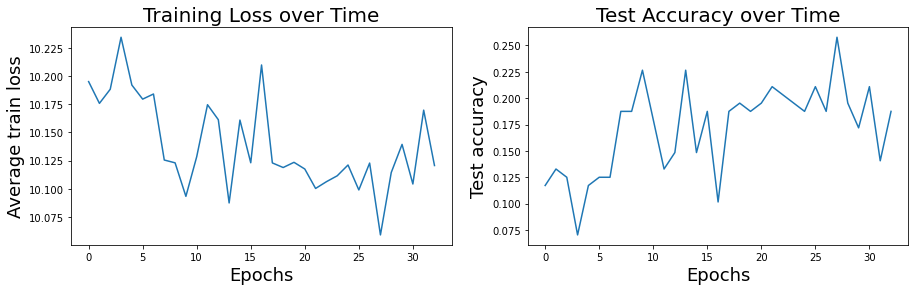

In [104]:
import matplotlib.pyplot as plt
x_axis = np.arange(len(train_loss_over_time))

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=15,h=4)
ax[0].plot(x_axis, train_loss_over_time)
ax[0].set_xlabel('Epochs',fontsize=18)
ax[0].set_ylabel('Average train loss',fontsize=18)
ax[0].set_title('Training Loss over Time',fontsize=20)
ax[1].plot(x_axis, train_accuracy_over_time)
ax[1].set_xlabel('Epochs',fontsize=18)
ax[1].set_ylabel('Test accuracy',fontsize=18)
ax[1].set_title('Test Accuracy over Time',fontsize=20)
plt.show()
#fig.savefig('mnist_stats.jpg')

In [138]:
#result(283) is(9) a(8) change(499) of(4)
test_data = [283,9,499,4]
test_data = np.array(test_data)
test_data = np.expand_dims(test_data, axis=0)
preds = model.predict(test_data)
preds = -preds[0]
preds = preds.argsort()
preds = np.argwhere(a>29990)
print([reverse_dictionary[pred[0]] for pred in preds])

['exception', 'Square', 'systematic', 'beneath', 'Easter', 'overthrow', '3.1', 'screenplays', 'contrived']
